In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

from keras.activations import *
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,Dropout,LSTM,GRU
from sklearn.metrics import classification_report,accuracy_score, precision_score, recall_score, f1_score ,confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from yellowbrick.classifier import PrecisionRecallCurve, ROCAUC, ConfusionMatrix


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
x_train = pd.read_csv(r"/kaggle/input/arabic-handwritten-digits-dataset-ahdd/Train_dataset 60kx784.csv",header=None)
y_train = pd.read_csv(r"/kaggle/input/arabic-handwritten-digits-dataset-ahdd/Train_dataset (Label)60kx1.csv",header=None)

x_test = pd.read_csv(r"/kaggle/input/arabic-handwritten-digits-dataset-ahdd/Test_dataset 10kx784.csv",header=None)
y_test = pd.read_csv(r"/kaggle/input/arabic-handwritten-digits-dataset-ahdd/Test_dataset (Label) 10kx1.csv",header=None)

print("x_train.shape =", x_train.shape, "\ny_train.shape =", 
      y_train.shape, "\nx_test.shape =", x_test.shape, "\ny_test.shape =", y_test.shape)

x_train.shape = (60000, 784) 
y_train.shape = (60000, 1) 
x_test.shape = (10000, 784) 
y_test.shape = (10000, 1)


In [3]:
x_train = x_train.iloc[:,:].values
x_test = x_test.iloc[:,:].values
y_train = y_train.iloc[:,:].values
y_test = y_test.iloc[:,:].values
print("x_train.shape =", x_train.shape, "\ny_train.shape =", 
      y_train.shape, "\nx_test.shape =", x_test.shape, "\ny_test.shape =", y_test.shape)

x_train.shape = (60000, 784) 
y_train.shape = (60000, 1) 
x_test.shape = (10000, 784) 
y_test.shape = (10000, 1)


In [4]:
x_train = x_train.reshape(-1,28,28,1)
x_test = x_test.reshape(-1,28,28,1)

x_train = x_train / 255.0
x_test = x_test / 255.0

print(x_train.shape, x_test.shape)

(60000, 28, 28, 1) (10000, 28, 28, 1)


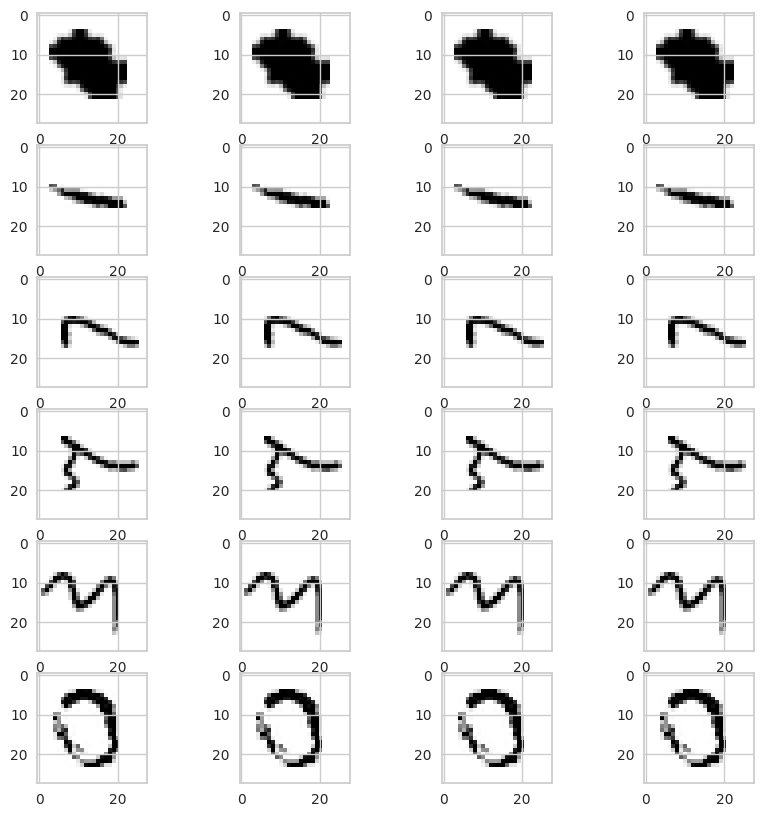

In [5]:
fig, ax = plt.subplots(6,4,figsize=(10,10))

for i in range(6):
    for j in range(4):
        ax[i,j].imshow(x_train[i])

In [6]:
total_classes = len(np.unique(y_train))+1
y_train = to_categorical(y_train,total_classes)
y_test = to_categorical(y_test, total_classes)

print(y_train.shape)
print(y_test.shape)

(60000, 11)
(10000, 11)


In [7]:
from tensorflow.keras import layers
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input,Conv1D,Flatten,BatchNormalization,SpatialDropout1D, MaxPooling1D,Dense,GlobalMaxPooling1D,Embedding
class attention(layers.Layer):
    def _init_(self,**kwargs):
        super(attention,self)._init_(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name="att_weight",shape=(input_shape[-1],1),initializer="normal")
        self.b=self.add_weight(name="att_bias",shape=(input_shape[1],1),initializer="zeros")        
        super(attention, self).build(input_shape)

    def call(self,x):
        et=K.squeeze(K.tanh(K.dot(x,self.W)+self.b),axis=-1)
        at=K.softmax(et)
        at=K.expand_dims(at,axis=-1)
        output=x*at
        return K.sum(output,axis=1)

    def compute_output_shape(self,input_shape):
        return (input_shape[0],input_shape[-1])

    def get_config(self):
        return super(attention,self).get_config()

In [8]:
model = Sequential([
    
    
    LSTM(256, return_sequences=True, dropout=0.25, input_shape=(28,28)),
    Dense(256, activation='relu'),
    
    LSTM(128, return_sequences=True, dropout=0.5),
    Dense(128, activation='relu'),
    
    LSTM(64, return_sequences=True, dropout=0.5),
    Dense(64, activation='relu'),
    
    LSTM(32, return_sequences=True, dropout=0.5),
    Dense(32, activation='relu'),
    
    attention(),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(256, activation='relu'),
    Dense(total_classes, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 28, 256)           291840    
                                                                 
 dense (Dense)               (None, 28, 256)           65792     
                                                                 
 lstm_1 (LSTM)               (None, 28, 128)           197120    
                                                                 
 dense_1 (Dense)             (None, 28, 128)           16512     
                                                                 
 lstm_2 (LSTM)               (None, 28, 64)            49408     
                                                                 
 dense_2 (Dense)             (None, 28, 64)            4160      
                                                                 
 lstm_3 (LSTM)               (None, 28, 32)            1

In [9]:
model.compile(loss='categorical_crossentropy', optimizer='adam', 
                  metrics=['accuracy'])

In [10]:
history = model.fit(x_train,y_train,
                    #steps_per_epoch=len(x_train)//128,
                    batch_size=128,
                    epochs=150,
                    validation_data=(x_test, y_test),
                   # validation_steps=50
                   )

Epoch 1/150
469/469 [==============================] - 23s 21ms/step - loss: 0.6339 - accuracy: 0.7890 - val_loss: 0.1979 - val_accuracy: 0.9495
Epoch 2/150
469/469 [==============================] - 8s 18ms/step - loss: 0.1253 - accuracy: 0.9660 - val_loss: 0.1078 - val_accuracy: 0.9725
Epoch 3/150
469/469 [==============================] - 8s 18ms/step - loss: 0.0846 - accuracy: 0.9777 - val_loss: 0.0788 - val_accuracy: 0.9794
Epoch 4/150
469/469 [==============================] - 8s 18ms/step - loss: 0.0677 - accuracy: 0.9815 - val_loss: 0.0733 - val_accuracy: 0.9818
Epoch 5/150
469/469 [==============================] - 8s 18ms/step - loss: 0.0565 - accuracy: 0.9848 - val_loss: 0.0675 - val_accuracy: 0.9828
Epoch 6/150
469/469 [==============================] - 8s 18ms/step - loss: 0.0526 - accuracy: 0.9857 - val_loss: 0.0455 - val_accuracy: 0.9870
Epoch 7/150
469/469 [==============================] - 8s 18ms/step - loss: 0.0455 - accuracy: 0.9878 - val_loss: 0.0496 - val_accuracy

In [11]:
y_held_pred=model.predict(x_test)

313/313 [==============================] - 3s 6ms/step


In [12]:
y_pred=np.argmax(y_held_pred, axis=1)
y_test_1=np.argmax(y_test, axis=1)

print(y_test_1.shape)
print(y_pred.shape)

(10000,)
(10000,)


In [13]:
model.evaluate(x_test,y_test)

313/313 [==============================] - 2s 7ms/step - loss: 0.0635 - accuracy: 0.9914


[0.06352120637893677, 0.9914000034332275]

In [14]:
his=model.evaluate(x_test, y_test, verbose=2);
print(his)

313/313 - 2s - loss: 0.0635 - accuracy: 0.9914 - 2s/epoch - 6ms/step
[0.06352120637893677, 0.9914000034332275]


In [15]:
y_held_pred_train=model.predict(x_train)

1875/1875 [==============================] - 12s 6ms/step


In [16]:
y_pred_train=np.argmax(y_held_pred_train, axis=1)
y_train_1=np.argmax(y_train, axis=1)

print(y_train_1.shape)
print(y_pred_train.shape)
model.evaluate(x_train, y_train, verbose=2);

(60000,)
(60000,)
1875/1875 - 12s - loss: 0.0016 - accuracy: 0.9997 - 12s/epoch - 7ms/step


<Axes: title={'center': 'Actual vs. Predicted'}, xlabel='Actual G*', ylabel='Predicted G*'>

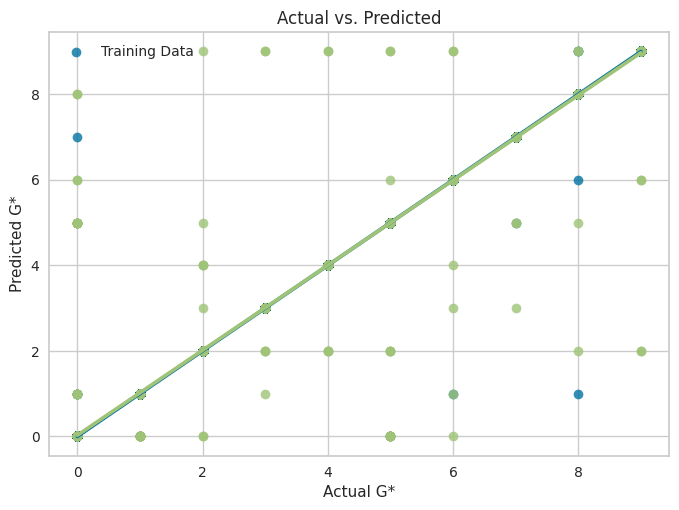

In [17]:
import seaborn as sns

sns.regplot(x=y_train_1,y=y_pred_train, label="Training Data")

plt.xlabel('Actual G*')
plt.ylabel('Predicted G*')
plt.title('Actual vs. Predicted')
plt.legend(loc="upper left")

sns.regplot(x=y_test_1,y=y_pred, label="Testing Data")

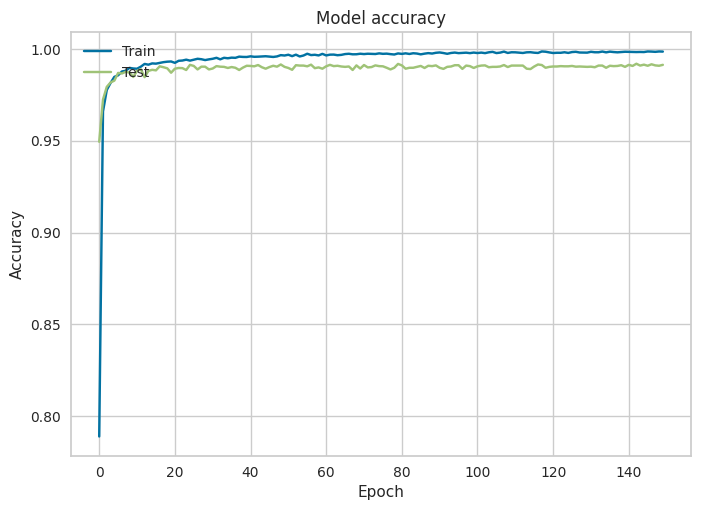

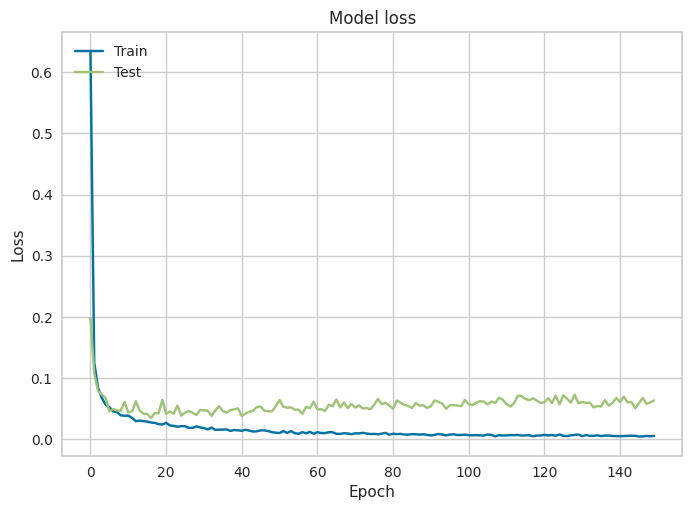

In [18]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [19]:
y_predicted = model.predict(x_test)
y_grand_truth = y_test
y_predicted = np.argmax(y_predicted,axis=1)
y_grand_truth = np.argmax(y_grand_truth,axis=1)
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_grand_truth, y_predicted)

313/313 [==============================] - 2s 7ms/step


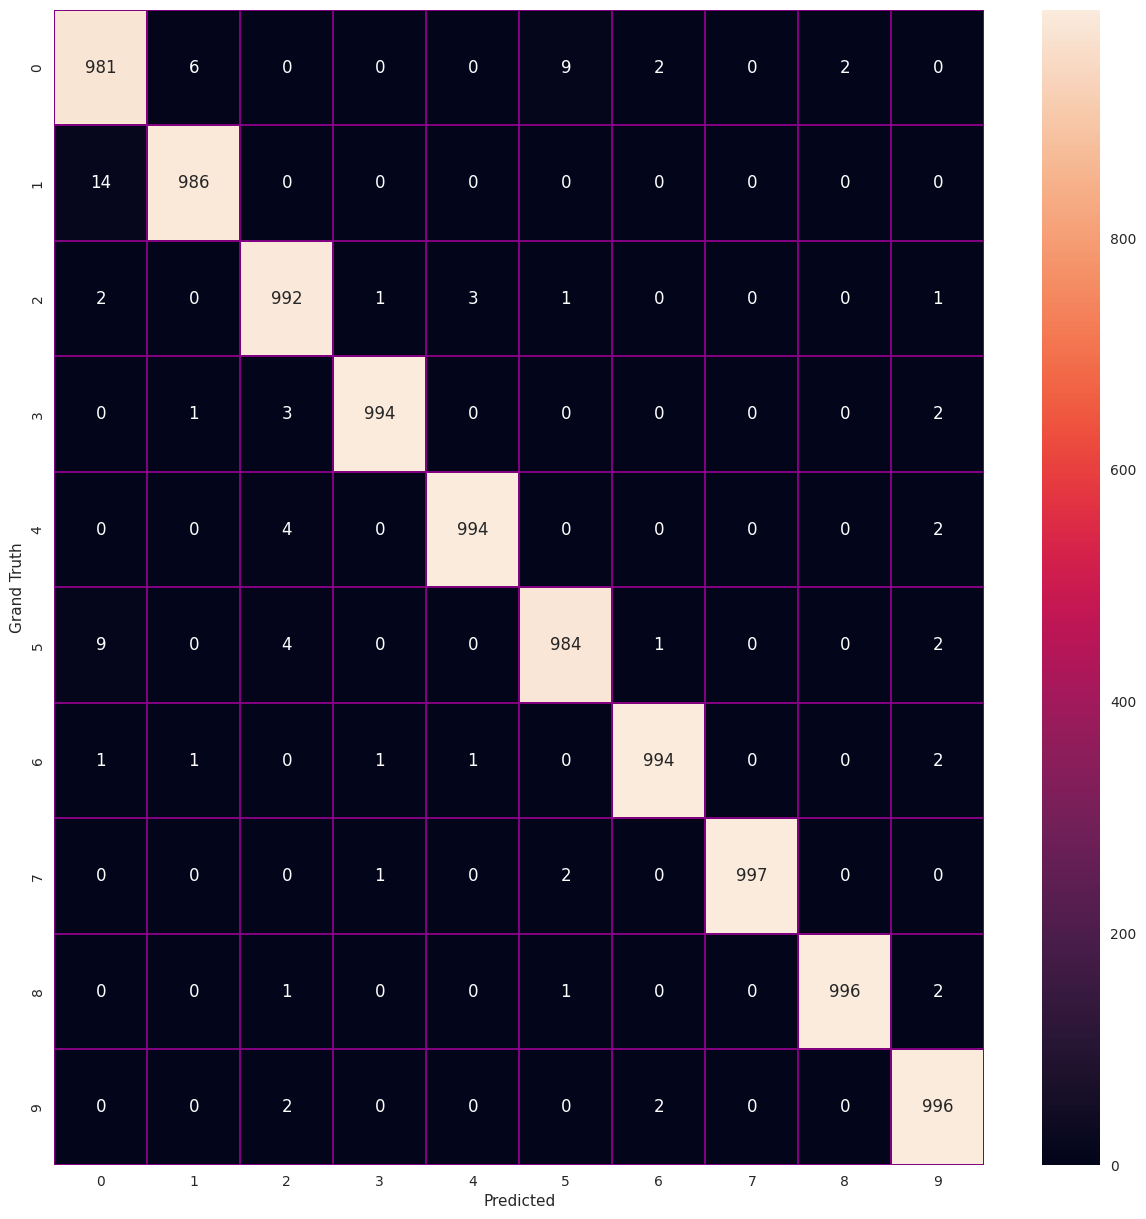

In [20]:
f, ax = plt.subplots(figsize=(15,15))
sns.heatmap(cm,fmt=".0f", annot=True,linewidths=0.2, linecolor="purple", ax=ax)
plt.xlabel("Predicted")
plt.ylabel("Grand Truth")
plt.show()

In [21]:
scores = np.zeros((10,3))
def calc_F1(num):
  TP = cm[num,num]
  FN = np.sum(cm[num,:])-cm[num,num]
  FP = np.sum(cm[:,num])-cm[num,num]
  precision = TP/(TP+FP)
  recall = TP/(TP+FN)
  F1_score = 2*(recall * precision) / (recall + precision)
  return precision, recall, F1_score
for i in range(10):
   precision, recall, F1_score = calc_F1(i)
   scores[i,:] = precision, recall, F1_score
scores_frame = pd.DataFrame(scores,columns=["Precision", "Recall", "F1 Score"], index=[list(range(0, 10))])

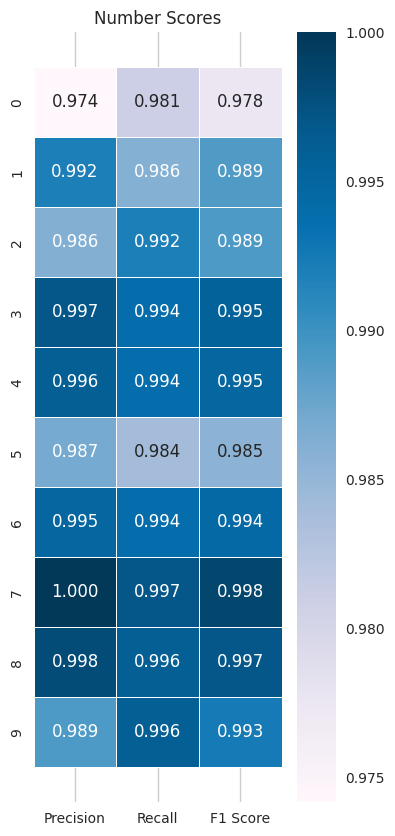

In [22]:
f, ax = plt.subplots(figsize = (4,10))
ax.set_title('Number Scores')
sns.heatmap(scores_frame, annot=True, fmt=".3f", linewidths=0.5, cmap="PuBu", cbar=True, ax=ax)
bottom, top = ax.get_ylim()
plt.ylabel("")
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

In [23]:
# Functions: Performance Evaluation 

def Performance(Model , y_predd): 
    
    # model accuracy
    accuracy = accuracy_score(y_test_1, y_predd)
    print( Model +' Accuracy:'+'\033[1m {:.2f}%'.format(accuracy*100))
    
    # model Classification Report
    print('\nClassification Report: '+'\033[0m')
    print('*' * 22)
    print(classification_report(y_test_1, y_predd))

In [24]:
Performance('LSTM' , y_pred)

LSTM Accuracy: 99.14%

Classification Report: 
**********************
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      1000
           1       0.99      0.99      0.99      1000
           2       0.99      0.99      0.99      1000
           3       1.00      0.99      1.00      1000
           4       1.00      0.99      0.99      1000
           5       0.99      0.98      0.99      1000
           6       0.99      0.99      0.99      1000
           7       1.00      1.00      1.00      1000
           8       1.00      1.00      1.00      1000
           9       0.99      1.00      0.99      1000

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000









### 